# Predicting Earthquake Magnitude and Risk Factors Using Geospatial and Temporal Analytics

**Team: ADA_32**
* ISHAAN M C - PES1UG22AM071
* NISHAAN PADANTHAYA - PES1UG22AM107
* MOHITH D K - PES1UG22AM097
* MANOJ G B -PES1UG22AM092

In [114]:
!pip install spectral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 4.6 MB/s eta 0:00:00a 0:00:01


In [115]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from scipy.spatial import distance_matrix
import scipy.sparse as sp

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import geopandas as gpd
import folium
from folium.plugins import HeatMap
import networkx as nx
from spektral.data import Graph, Dataset
from shapely.geometry import Point


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/earthquake-dataset/earthquake_data.csv
/kaggle/input/earthquake-dataset/earthquake_1995-2023.csv


In [116]:
df = pd.read_csv('/kaggle/input/earthquake-dataset/earthquake_1995-2023.csv')

In [117]:
df

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,16-08-2023 12:47,7,4,green,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",NaN,Vanuatu
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,19-07-2023 00:22,8,6,yellow,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",NaN,NaN
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,17-07-2023 03:05,7,5,green,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",South America,Argentina
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,16-07-2023 06:48,6,6,green,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",NaN,NaN
4,M 7.3 - Alaska Peninsula,7.3,16-07-2023 06:48,0,5,NaN,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"M 7.1 - 85 km S of Tungor, Russia",7.1,27-05-1995 13:03,0,9,NaN,0,776,us,0,0.000000,0.0,mwb,11.000,52.6290,142.8270,"Tungor, Russia",Asia,Russia
996,"M 7.7 - 249 km E of Vao, New Caledonia",7.7,16-05-1995 20:12,0,4,NaN,0,912,us,0,0.000000,0.0,mw,20.200,-23.0080,169.9000,"Vao, New Caledonia",NaN,NaN
997,"M 6.9 - 27 km NNW of Maubara, Timor Leste",6.9,14-05-1995 11:33,0,6,NaN,0,732,us,0,0.000000,0.0,mw,11.200,-8.3780,125.1270,"Maubara, Timor Leste",NaN,Indonesia
998,"M 6.6 - 10 km W of Aianí, Greece",6.6,13-05-1995 08:47,0,9,NaN,0,670,us,0,0.000000,0.0,mw,14.000,40.1490,21.6950,"Aianí, Greece",Europe,Greece


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   date_time  1000 non-null   object 
 3   cdi        1000 non-null   int64  
 4   mmi        1000 non-null   int64  
 5   alert      449 non-null    object 
 6   tsunami    1000 non-null   int64  
 7   sig        1000 non-null   int64  
 8   net        1000 non-null   object 
 9   nst        1000 non-null   int64  
 10  dmin       1000 non-null   float64
 11  gap        1000 non-null   float64
 12  magType    1000 non-null   object 
 13  depth      1000 non-null   float64
 14  latitude   1000 non-null   float64
 15  longitude  1000 non-null   float64
 16  location   994 non-null    object 
 17  continent  284 non-null    object 
 18  country    651 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 

In [119]:
df.isna().sum()

title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        551
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       6
continent    716
country      349
dtype: int64

## Handling the missing values

- Extract the country off the Location attribute by splitting the location by comma if it exists

In [120]:
df_r = df['location'].str.split(pat=',', n=1, expand=True)
print(df_r.head(5)) 

                  0             1
0              Sola       Vanuatu
1          Intipucá   El Salvador
2          Loncopué     Argentina
3        Sand Point        Alaska
4  Alaska Peninsula          None


- Fill the missing values in the Country column with the extracted info

In [121]:
df['country'] = df['country'].fillna(df_r[1])  
print('\n', 'Missing values in the refined country column are : ', df['country'].isna().sum())


 Missing values in the refined country column are :  54


In [122]:
df = df.dropna(subset=['country','location','continent'], how='all')
print('\n', 'Missing values in the country column are: ', df['country'].isnull().sum())


 Missing values in the country column are:  51


- Replace the missing values in the location column with "Unkown" tag

In [123]:
print('\n', 'Missing location values Before : ', df['location'].isnull().sum())
df.loc[:, 'location'] = df['location'].fillna('unknown')
print('\n', 'Missing location values After  : ', df['location'].isnull().sum())


 Missing location values Before :  3

 Missing location values After  :  0


- Fill the remaining missing values in the Country column with its corresponding Locations

In [124]:
## We try to fill location names as missing country names, and refine it later

df.loc[:, 'country'] = df['country'].fillna(df['location'])

df['country'].isnull().sum()

0

- Fill the missing values in alert attribute with None

In [125]:
df['alert'] = df['alert'].fillna('None')

In [126]:
df['alert'].value_counts()

alert
None      551
green     350
yellow     59
orange     24
red        13
Name: count, dtype: int64

- Drop the continent attribute

In [127]:
df.drop('continent', axis=1, inplace=True)

- We have successfully dealt with missing values!

In [128]:
df.isna().sum()

title        0
magnitude    0
date_time    0
cdi          0
mmi          0
alert        0
tsunami      0
sig          0
net          0
nst          0
dmin         0
gap          0
magType      0
depth        0
latitude     0
longitude    0
location     0
country      0
dtype: int64

### Let's pre-process the Country attribute

In [129]:
df['country'].unique()

array(['Vanuatu', ' El Salvador', 'Argentina', ' Alaska',
       'Alaska Peninsula', ' Antigua and Barbuda', 'Tonga',
       'the Fiji Islands', 'Colombia', 'the Loyalty Islands', ' Tonga',
       'Indonesia', ' New Zealand', 'Russian Federation (the)',
       'Papua New Guinea', 'Afghanistan', 'Ecuador',
       'Kermadec Islands region', ' Vanuatu', 'Tajikistan', 'Turkiye',
       'Solomon Islands', ' Indonesia', 'Fiji', 'Panama', 'Mexico',
       'Taiwan', "People's Republic of China", 'the Kermadec Islands',
       'Philippines', 'Brazil', 'Peru', ' Nicaragua', ' New Caledonia',
       ' Japan', ' Cyprus', 'United States of America', 'Vanuatu region',
       'Antarctica', 'South Sandwich Islands region', 'Haiti',
       ' Philippines', ' Panama', ' Wallis and Futuna',
       'Mauritius - Reunion region', 'Japan', ' Russia', 'Mongolia',
       ' Chile', 'Greece', 'central Mid-Atlantic Ridge', 'Chile',
       ' Solomon Islands', ' Greece', 'Russia', ' Jamaica', 'Turkey',
       ' Fiji

- We can see that there are a lot of repeated countries in this list, like 'New Zealand', 'New Zealand Region' and ' New Zealand'.
- We will map the repetitive countries to a single country.

In [130]:
# Dictionary to map country variations to standardized country names
country_mapping = {
    ' El Salvador': 'El Salvador',
    ' Alaska': 'United States of America',
    'Alaska Peninsula': 'United States of America',
    ' Antigua and Barbuda': 'Antigua and Barbuda',
    'the Fiji Islands': 'Fiji',
    ' the Loyalty Islands': 'New Caledonia',
    ' Tonga': 'Tonga',
    ' Indonesia': 'Indonesia',
    ' New Zealand': 'New Zealand',
    'Russian Federation (the)': 'Russia',
    ' Turkiye': 'Turkey',
    'Turkiye': 'Turkey',
    ' Solomon Islands': 'Solomon Islands',
    ' the Kermadec Islands': 'New Zealand',
    ' Philippines': 'Philippines',
    'Philippine Islands region': 'Philippines',
    ' Panama': 'Panama',
    ' Wallis and Futuna': 'Wallis and Futuna',
    ' Mauritius - Reunion region': 'Mauritius',
    ' Russia': 'Russia',
    ' Chile': 'Chile',
    ' Greece': 'Greece',
    ' Fiji': 'Fiji',
    'United Kingdom of Great Britain and Northern Ireland (the)': 'United Kingdom',
    ' Australia': 'Australia',
    ' South Sandwich Islands': 'South Sandwich Islands',
    ' South Georgia and the South Sandwich Islands': 'South Georgia and the South Sandwich Islands',
    ' Svalbard and Jan Mayen': 'Svalbard and Jan Mayen',
    ' Canada': 'Canada',
    ' Mexico': 'Mexico',
    ' Russia region': 'Russia',
    ' New Zealand region': 'New Zealand',
    ' Guatemala': 'Guatemala',
    ' India region': 'India',
    ' Aleutian Islands, Alaska': 'United States of America',
    ' Japan region': 'Japan',
    ' Japan': 'Japan',
    ' Papua New Guinea': 'Papua New Guinea',
    ' Fiji region': 'Fiji',
    ' Colombia': 'Colombia',
    ' Samoa': 'Samoa',
    ' India': 'India',
    ' Costa Rica': 'Costa Rica',
    ' Trinidad and Tobago': 'Trinidad and Tobago',
    ' Turkey': 'Turkey',
    ' United States of America': 'United States of America',
    ' Micronesia region': 'Micronesia',
    ' New Caledonia': 'New Caledonia',
    ' Northern Mariana Islands': 'Northern Mariana Islands',
    ' French Polynesia': 'French Polynesia',
    ' United States': 'United States of America',
    ' Vanuatu': 'Vanuatu',
    'Vanuatu region': 'Vanuatu',
    ' California': 'United States of America'
}

# Apply the mapping to the 'country' column
df.loc[:, 'country'] = df['country'].replace(country_mapping)

# Check the result
print(df['country'].unique())

['Vanuatu' 'El Salvador' 'Argentina' 'United States of America'
 'Antigua and Barbuda' 'Tonga' 'Fiji' 'Colombia' 'the Loyalty Islands'
 'Indonesia' 'New Zealand' 'Russia' 'Papua New Guinea' 'Afghanistan'
 'Ecuador' 'Kermadec Islands region' 'Tajikistan' 'Turkey'
 'Solomon Islands' 'Panama' 'Mexico' 'Taiwan' "People's Republic of China"
 'the Kermadec Islands' 'Philippines' 'Brazil' 'Peru' ' Nicaragua'
 'New Caledonia' 'Japan' ' Cyprus' 'Antarctica'
 'South Sandwich Islands region' 'Haiti' 'Wallis and Futuna'
 'Mauritius - Reunion region' 'Mongolia' 'Chile' 'Greece'
 'central Mid-Atlantic Ridge' ' Jamaica' 'United Kingdom' 'Australia'
 'South Sandwich Islands' 'Prince Edward Islands region'
 'South Georgia and the South Sandwich Islands' 'Svalbard and Jan Mayen'
 'Canada' 'Venezuela' 'Bolivia' ' Honduras' 'Bouvet Island region'
 'Costa Rica' 'Iran' 'Guatemala' 'Botswana' 'Italy' 'Myanmar'
 'Northern Mariana Islands' 'India' ' Barbados' 'Nepal' 'Fiji region'
 ' Guam' 'Micronesia region' 

In [131]:
df['country'].value_counts()

country
Indonesia              150
Papua New Guinea        94
Japan                   75
Chile                   58
Vanuatu                 56
                      ... 
Kuril Islands            1
Mozambique               1
South Indian Ocean       1
Trinidad and Tobago      1
Saudi Arabia             1
Name: count, Length: 87, dtype: int64

In [132]:
df.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,country
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,16-08-2023 12:47,7,4,green,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",Vanuatu
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,19-07-2023 00:22,8,6,yellow,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",El Salvador
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,17-07-2023 03:05,7,5,green,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",Argentina
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,16-07-2023 06:48,6,6,green,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",United States of America
4,M 7.3 - Alaska Peninsula,7.3,16-07-2023 06:48,0,5,None,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,United States of America


- Let's check for duplicates

In [133]:
df = df.drop_duplicates()
print(df.shape)

(997, 18)


- There are no duplicates

### Let's break the date_time attribute to individual columns: Year/Month/Date/Day/Hour

In [134]:
df['date'] = pd.to_datetime(df['date_time'], dayfirst=True).dt.date
df['year'] = pd.to_datetime(df['date_time'], dayfirst=True).dt.year
df['month'] = pd.to_datetime(df['date_time'], dayfirst=True).dt.month
df['day'] = pd.to_datetime(df['date_time'], dayfirst=True).dt.day
df['hour'] = pd.to_datetime(df['date_time'], dayfirst=True).dt.round('h').dt.hour # round to the nearest hour

In [135]:
df[['date_time', 'date', 'day', 'month', 'year', 'hour']].head()

,date_time,date,day,month,year,hour
0,16-08-2023 12:47,2023-08-16,16,8,2023,13
1,19-07-2023 00:22,2023-07-19,19,7,2023,0
2,17-07-2023 03:05,2023-07-17,17,7,2023,3
3,16-07-2023 06:48,2023-07-16,16,7,2023,7
4,16-07-2023 06:48,2023-07-16,16,7,2023,7


In [136]:
df = df.drop('date_time', axis=1)
df.head()

,title,magnitude,cdi,mmi,alert,tsunami,sig,net,nst,dmin,...,depth,latitude,longitude,location,country,date,year,month,day,hour
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,7,4,green,0,657,us,114,7.177000,...,192.955,-13.8814,167.1580,"Sola, Vanuatu",Vanuatu,2023-08-16,2023,8,16,13
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,8,6,yellow,0,775,us,92,0.679000,...,69.727,12.8140,-88.1265,"Intipucá, El Salvador",El Salvador,2023-07-19,2023,7,19,0
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,7,5,green,0,899,us,70,1.634000,...,171.371,-38.1911,-70.3731,"Loncopué, Argentina",Argentina,2023-07-17,2023,7,17,3
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,6,6,green,1,860,us,173,0.907000,...,32.571,54.3844,-160.6990,"Sand Point, Alaska",United States of America,2023-07-16,2023,7,16,7
4,M 7.3 - Alaska Peninsula,7.3,0,5,None,1,820,at,79,0.879451,...,21.000,54.4900,-160.7960,Alaska Peninsula,United States of America,2023-07-16,2023,7,16,7


## Data Visualizations

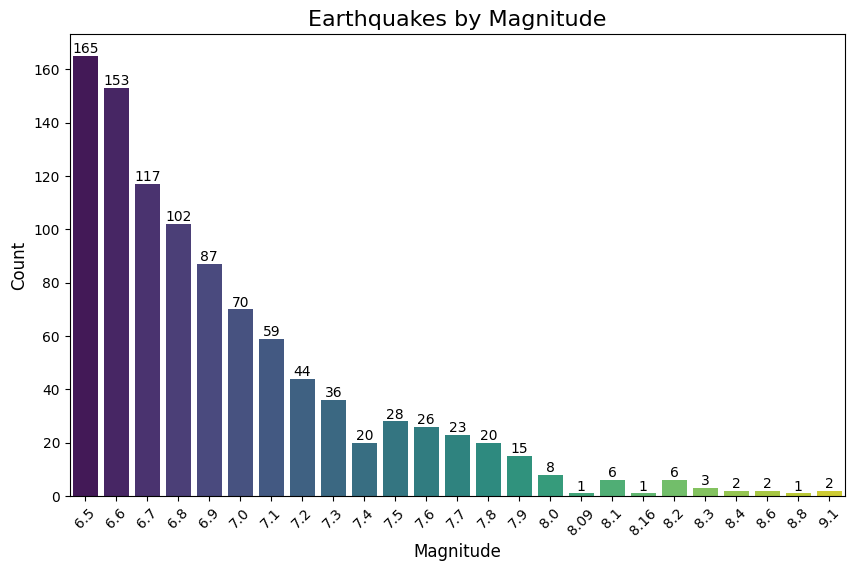

In [137]:
# Bar plot for earthquake magnitude counts
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='magnitude', data=df, palette='viridis')
plt.title('Earthquakes by Magnitude', fontsize=16)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Add value annotations
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

- We can observe a negative correlation between the magnitude of the earthquakes and the number of occurences.
- 6.5 magnitude has been recorded the most, followed by 6.6, 6.7, 6.8 and so on.

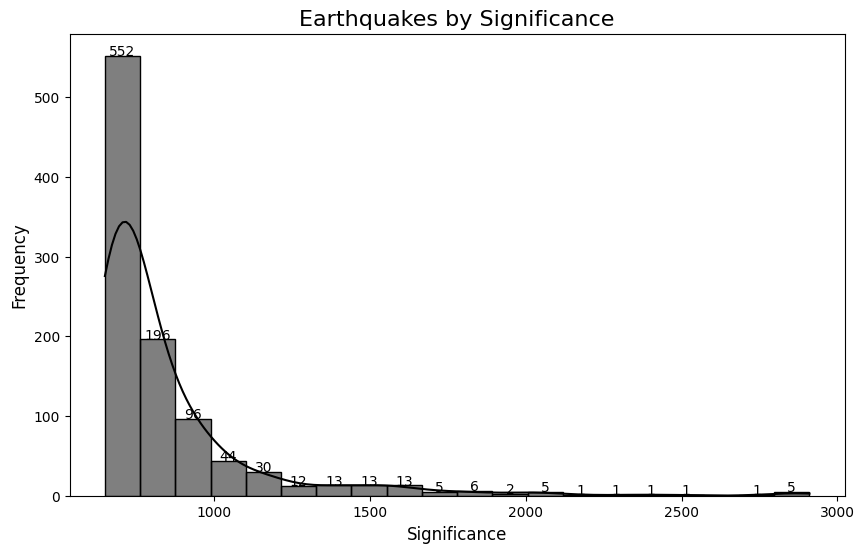

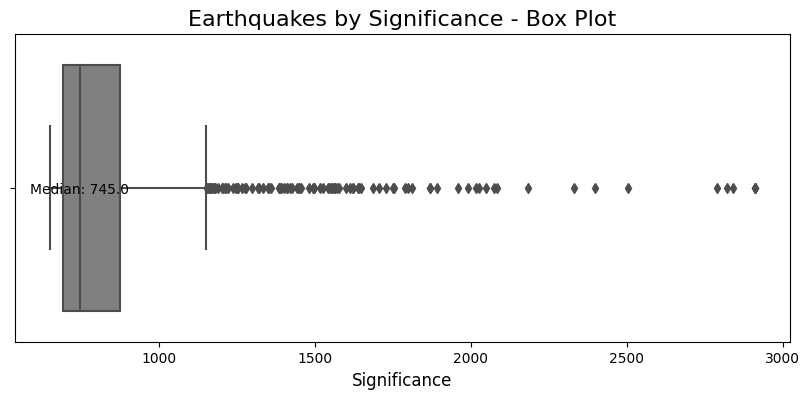

In [138]:
# Histogram of earthquake significance with annotations
plt.figure(figsize=(10, 6))
ax = sns.histplot(df['sig'], bins=20, kde=True, color='black')
plt.title('Earthquakes by Significance', fontsize=16)
plt.xlabel('Significance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display max frequency on histogram bars
for patch in ax.patches:
    if patch.get_height() > 0:
        ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.5, 
                int(patch.get_height()), ha='center', fontsize=10)

plt.show()

# Box plot for significance with median annotation
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x=df['sig'], color='grey')
plt.title('Earthquakes by Significance - Box Plot', fontsize=16)
plt.xlabel('Significance', fontsize=12)

# Display median value on box plot
median = df['sig'].median()
plt.text(median, 0.02, f'Median: {median}', ha='center', color='black', fontsize=10)

plt.show()

**Observations:**
- Most earthquakes have significance below 1000
- Median significance is 745

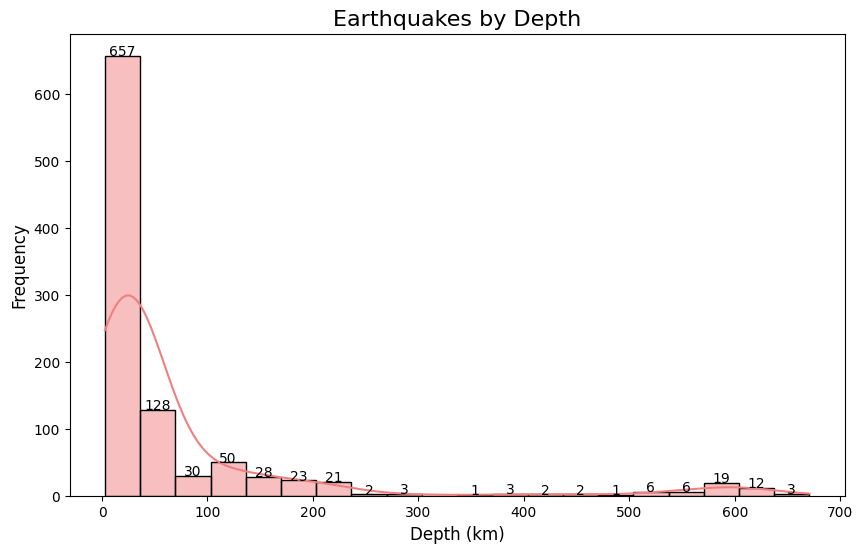

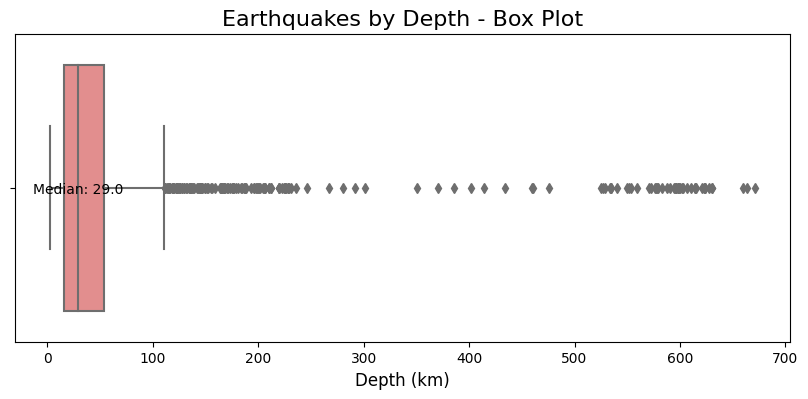

In [139]:
# Histogram of earthquake depth with annotations
plt.figure(figsize=(10, 6))
ax = sns.histplot(df['depth'], bins=20, kde=True, color='lightcoral')
plt.title('Earthquakes by Depth', fontsize=16)
plt.xlabel('Depth (km)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display frequency on histogram bars
for patch in ax.patches:
    if patch.get_height() > 0:
        ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.5, 
                int(patch.get_height()), ha='center', fontsize=10)

plt.show()

# Box plot for depth with median annotation
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x=df['depth'], color='lightcoral')
plt.title('Earthquakes by Depth - Box Plot', fontsize=16)
plt.xlabel('Depth (km)', fontsize=12)

# Display median value
median = df['depth'].median()
plt.text(median, 0.02, f'Median: {median}', ha='center', color='black', fontsize=10)

plt.show()

**Observations:**
- Most earthquakes have occured at depths below 100
- Median depth of earthquakes is 29

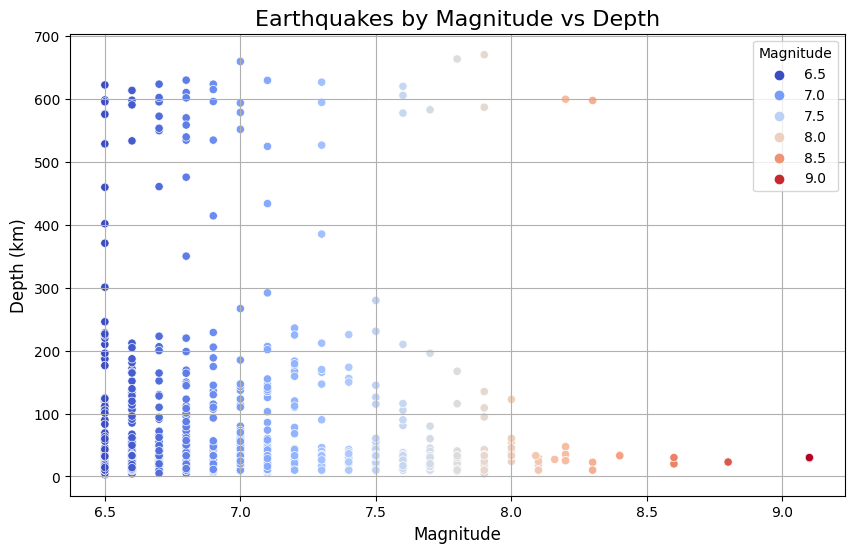

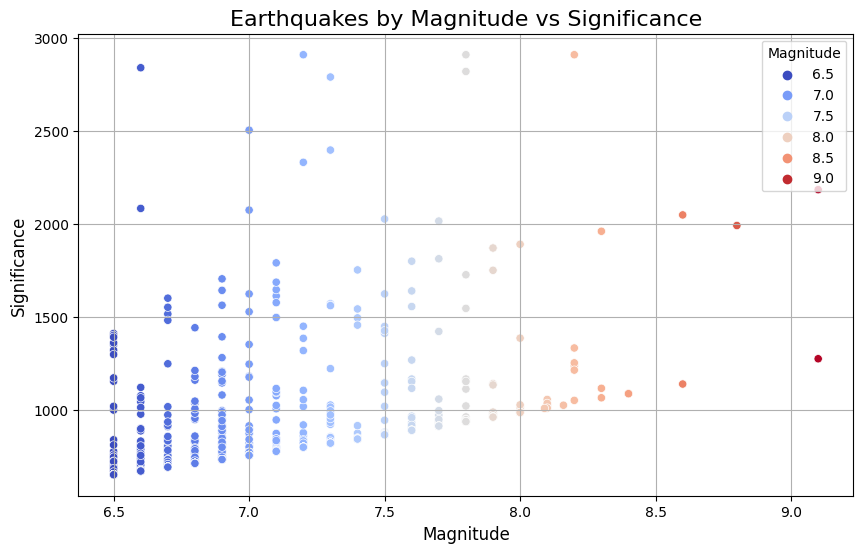

In [140]:
# Scatter plot of magnitude vs depth with trend line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='magnitude', y='depth', data=df, hue='magnitude', palette='coolwarm')
plt.title('Earthquakes by Magnitude vs Depth', fontsize=16)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Depth (km)', fontsize=12)
plt.legend(title='Magnitude')
plt.grid(visible=True)

plt.show()

# Scatter plot of magnitude vs significance with trend line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='magnitude', y='sig', data=df, hue='magnitude', palette='coolwarm')
plt.title('Earthquakes by Magnitude vs Significance', fontsize=16)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Significance', fontsize=12)
plt.legend(title='Magnitude')
plt.grid(visible=True)

plt.show()

- There is not much correlation between Magnitude and Depth
- There appeaers to be a certain correlation between Magnitude and Significance

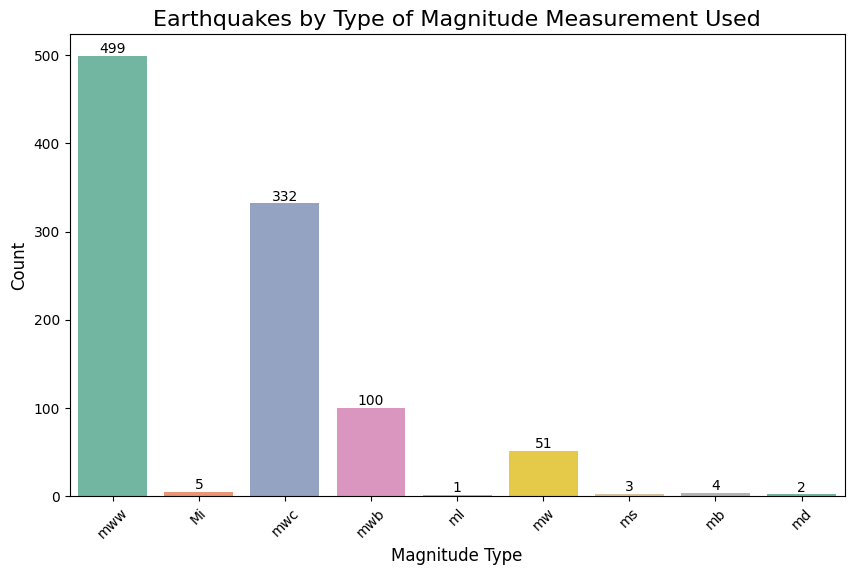

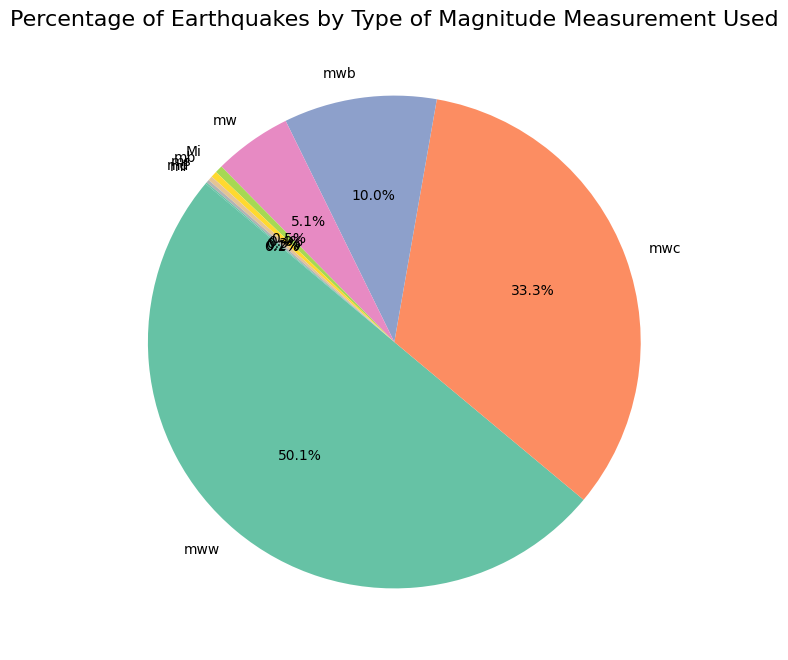

In [141]:
# Count plot for magnitude type with value annotations
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='magType', data=df, palette='Set2')
plt.title('Earthquakes by Type of Magnitude Measurement Used', fontsize=16)
plt.xlabel('Magnitude Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Add value annotations
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

# Pie chart for magnitude types with percentage annotations
plt.figure(figsize=(8, 8))
df['magType'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Percentage of Earthquakes by Type of Magnitude Measurement Used', fontsize=16)
plt.ylabel('')

plt.show()

**Observations:**
- mmw (Moment W-phase method) is the most widely used type of magnitude with 50.1% share.
- mwc (Centroid method) and mwb (Body wave method) are the second and the third most widely used types of magnitudes with 33.3% and 10% share, respectively.

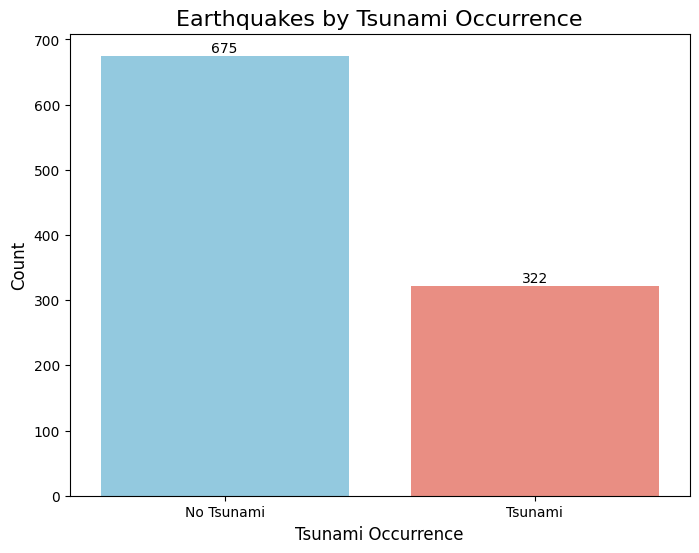

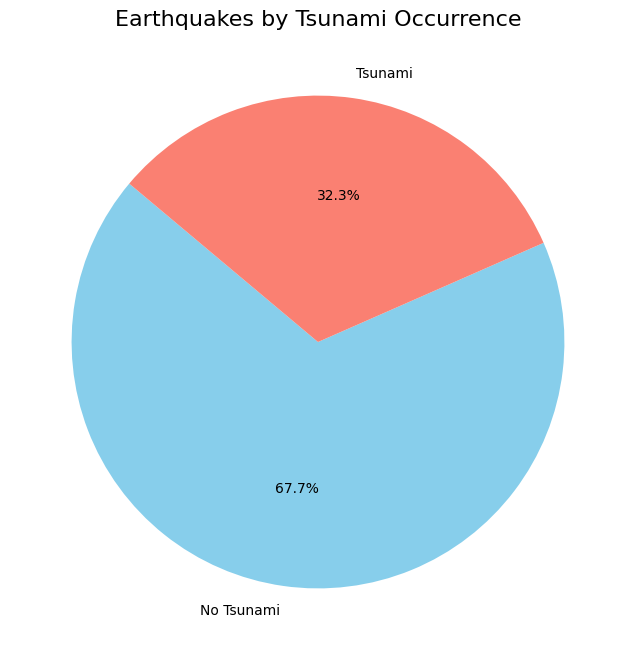

In [142]:
# Bar plot for tsunami occurrence counts
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='tsunami', data=df, palette=['skyblue', 'salmon'])
ax.set_xticklabels(['No Tsunami', 'Tsunami'])
plt.title('Earthquakes by Tsunami Occurrence', fontsize=16)
plt.xlabel('Tsunami Occurrence', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Value annotations on bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

# Pie chart for tsunami occurrence
plt.figure(figsize=(8, 8))
df['tsunami'].value_counts().plot.pie(
    labels=['No Tsunami', 'Tsunami'],
    autopct='%1.1f%%',
    startangle=140,
    colors=['skyblue', 'salmon']
)
plt.title('Earthquakes by Tsunami Occurrence', fontsize=16)
plt.ylabel('')  # Hide y-label for pie chart
plt.show()

Observations:
- 32.3% of earthquakes have effected in tsunami occurrence

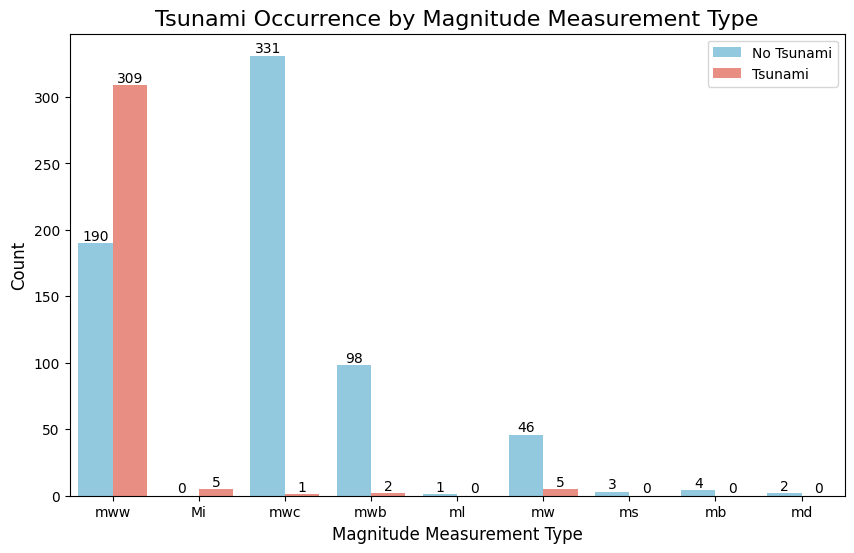

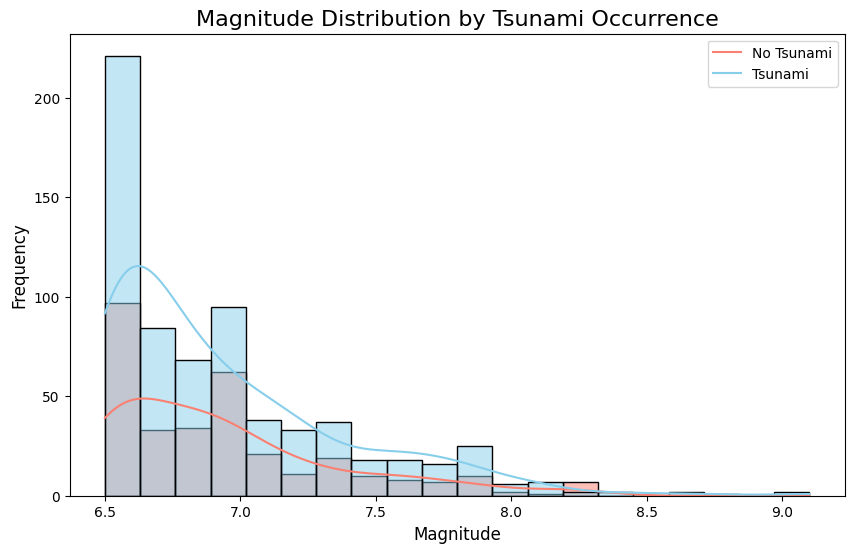

In [143]:
# Bar plot of tsunami occurrences by magnitude type
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='magType', hue='tsunami', data=df, palette=['skyblue', 'salmon'])
plt.title('Tsunami Occurrence by Magnitude Measurement Type', fontsize=16)
plt.xlabel('Magnitude Measurement Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(['No Tsunami', 'Tsunami'])

# Value annotations
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

# Histogram of magnitude with tsunami occurrence overlaid
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='magnitude', hue='tsunami', bins=20, kde=True, palette=['skyblue', 'salmon'])
plt.title('Magnitude Distribution by Tsunami Occurrence', fontsize=16)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(['No Tsunami', 'Tsunami'])

plt.show()

Observations:
- mmw is the widely used measurement type for earthquakes occuring in oceans.
- mwx is the widely used measurement type for earthwuakes occuring on land.

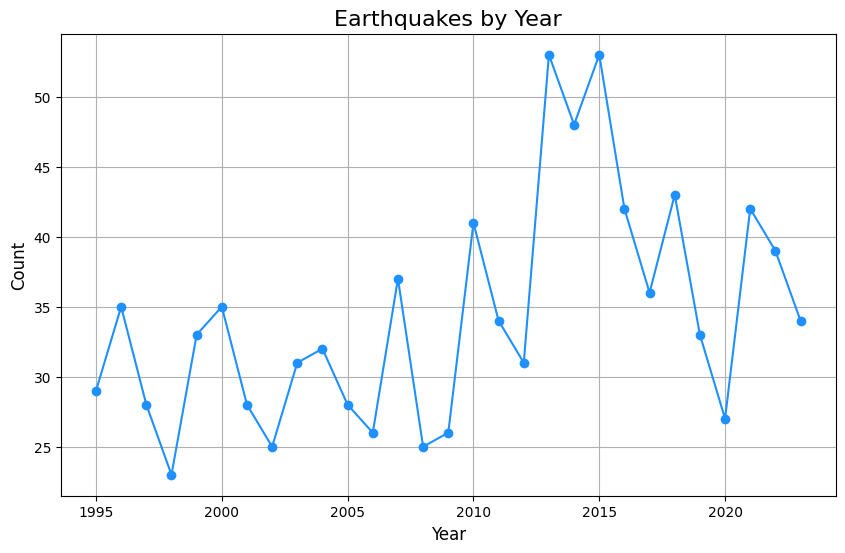

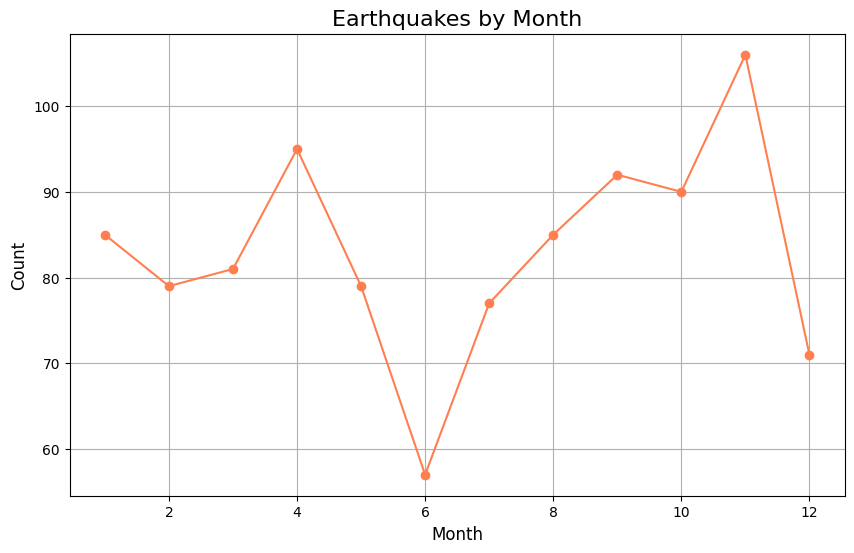

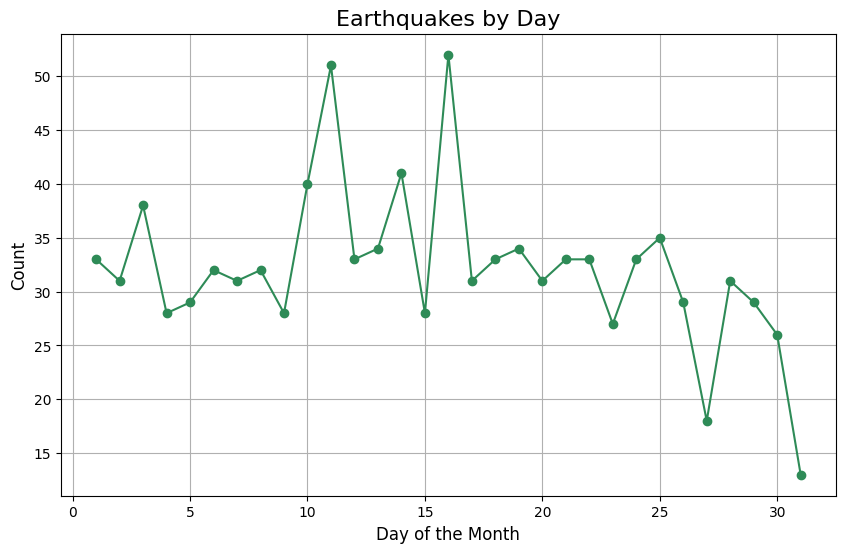

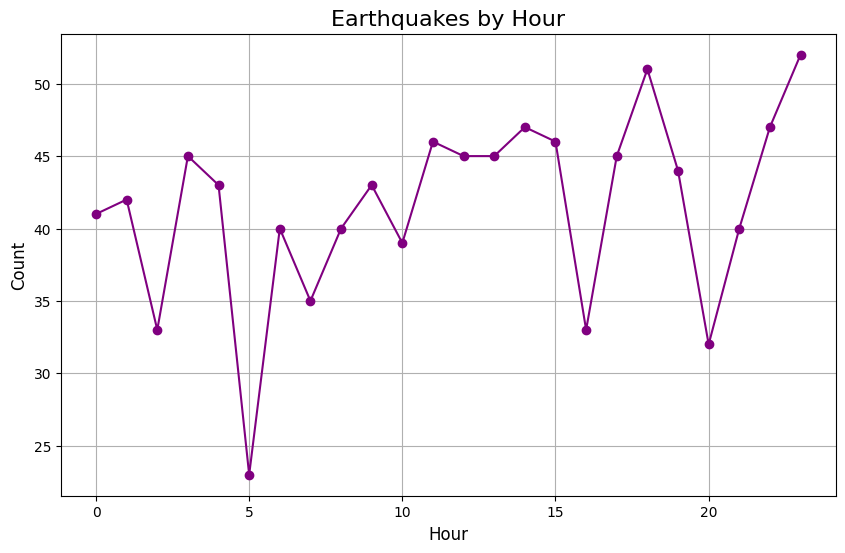

In [144]:
# Line plot by year
plt.figure(figsize=(10, 6))
df['year'].value_counts().sort_index().plot(kind='line', marker='o', color='dodgerblue')
plt.title('Earthquakes by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)

plt.show()

# Line plot by month
plt.figure(figsize=(10, 6))
df['month'].value_counts().sort_index().plot(kind='line', marker='o', color='coral')
plt.title('Earthquakes by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)

plt.show()

# Line plot by day
plt.figure(figsize=(10, 6))
df['day'].value_counts().sort_index().plot(kind='line', marker='o', color='seagreen')
plt.title('Earthquakes by Day', fontsize=16)
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)

plt.show()

# Line plot by hour
plt.figure(figsize=(10, 6))
df['hour'].value_counts().sort_index().plot(kind='line', marker='o', color='purple')
plt.title('Earthquakes by Hour', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)

plt.show()

**Observations:**
- The number of earthquakes were pretty high from 2013 to 2015
- November has the most eathquake occurrences while June has the least
- Occurrence of earthquakes is highest during the night (peaks at 11pm) and lowest during ealy mornings (lowest at 5am)

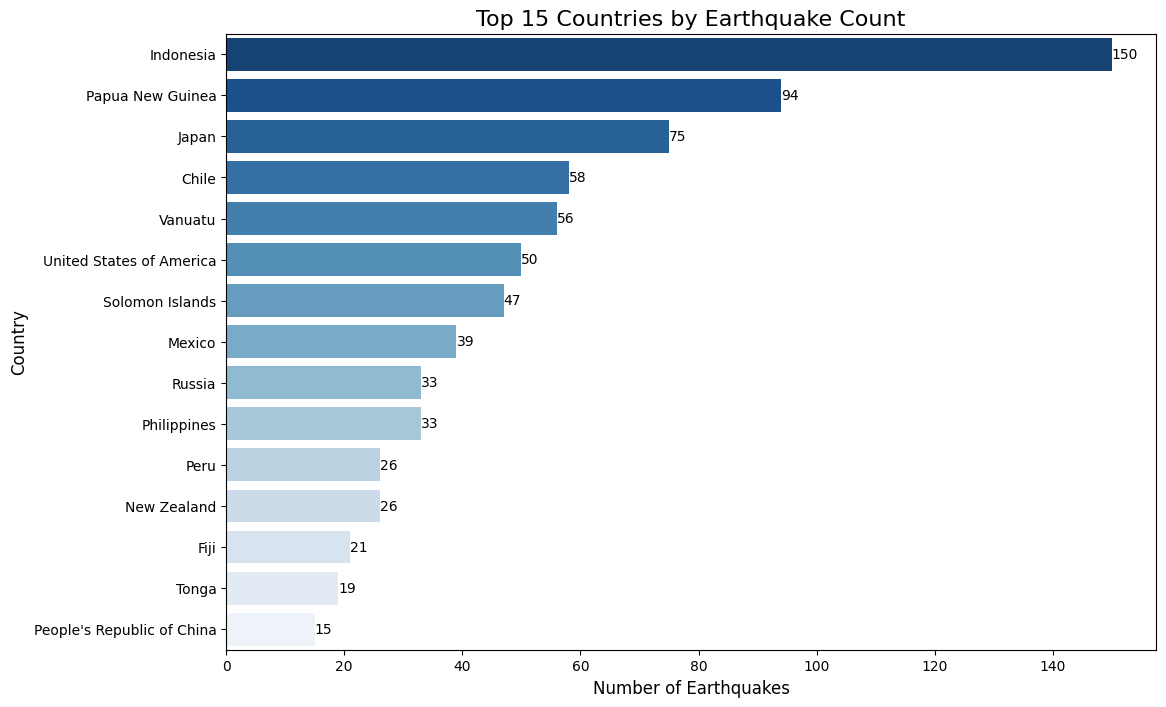

In [145]:
# Bar plot for the top 15 countries with the most earthquakes
top_countries = df['country'].value_counts().head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_countries.values, y=top_countries.index, palette='Blues_r')
plt.title('Top 15 Countries by Earthquake Count', fontsize=16)
plt.xlabel('Number of Earthquakes', fontsize=12)
plt.ylabel('Country', fontsize=12)

# Display values on bars
for index, value in enumerate(top_countries.values):
    ax.text(value, index, f'{value}', va='center', fontsize=10, color='black')

plt.show()

- Indonesia, Papa New Guinea and Japan have the highest number of earthquake occurrences from 1995-2023.

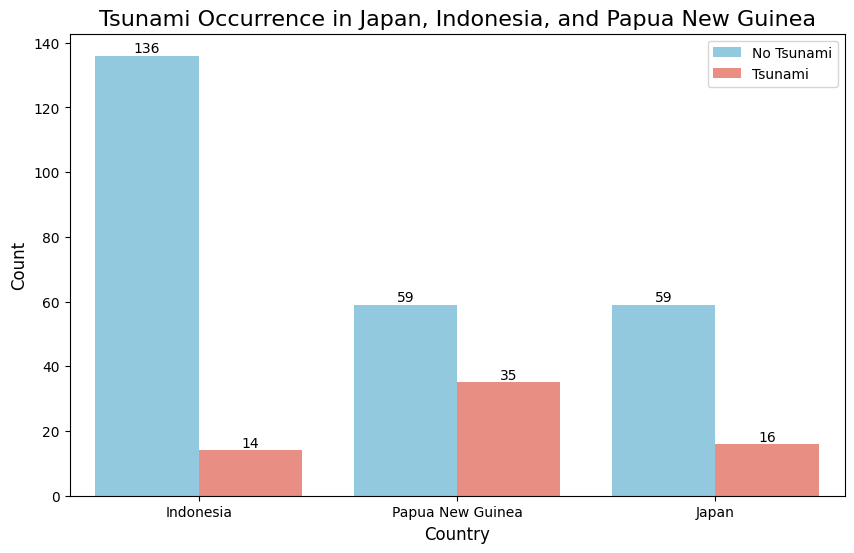

In [146]:
# Filter data for Japan, Indonesia, and Papua New Guinea
top_countries = df[df['country'].isin(['Japan', 'Indonesia', 'Papua New Guinea'])]

# Count tsunami occurrences for these countries
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='country', hue='tsunami', data=top_countries, palette=['skyblue', 'salmon'])
plt.title('Tsunami Occurrence in Japan, Indonesia, and Papua New Guinea', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(['No Tsunami', 'Tsunami'])

# Display values on bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

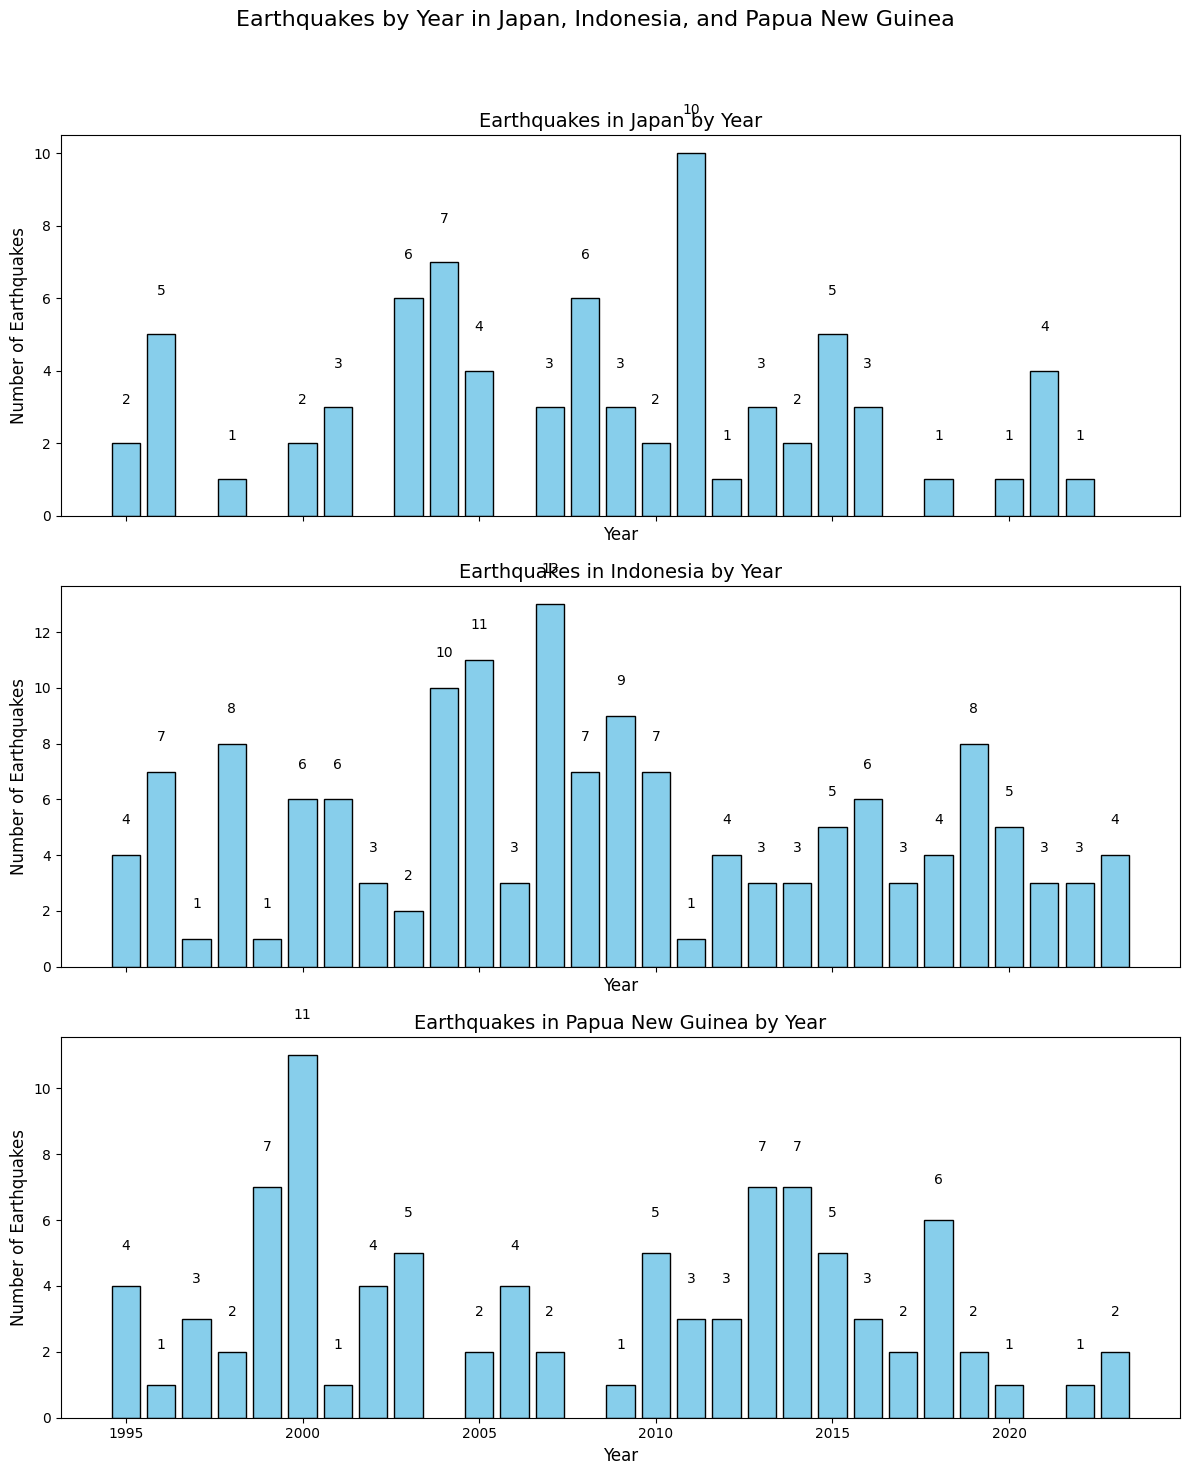

In [147]:
# Filter the dataset for the top 3 countries
top_3_countries = ['Japan', 'Indonesia', 'Papua New Guinea']
filtered_df = df[df['country'].isin(top_3_countries)]

# Plot bar charts for each country by year
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Earthquakes by Year in Japan, Indonesia, and Papua New Guinea', fontsize=16)

# Generate bar plot for each country
for ax, country in zip(axes, top_3_countries):
    yearly_counts = filtered_df[filtered_df['country'] == country].groupby('year').size()
    ax.bar(yearly_counts.index, yearly_counts.values, color='skyblue', edgecolor='black')
    ax.set_title(f'Earthquakes in {country} by Year', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Earthquakes', fontsize=12)
    
    # Display values on bars
    for i, v in enumerate(yearly_counts.values):
        ax.text(yearly_counts.index[i], v + 1, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Geospatial Analysis

**Kernel Density Estimation (KDE)**
* Purpose: KDE helps visualize regions with high earthquake densities (hotspots). By plotting latitude and longitude, we generate a heatmap that highlights frequently affected areas.

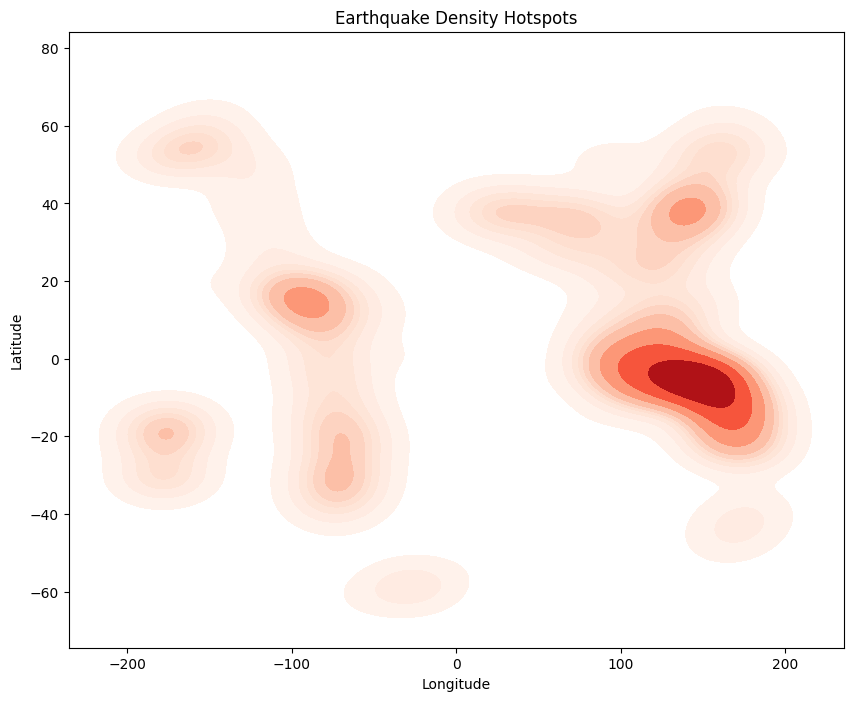

In [148]:
# KDE plot for latitude and longitude to visualize high-risk earthquake zones

plt.figure(figsize=(10, 8))
sns.kdeplot(x=df['longitude'], y=df['latitude'], cmap="Reds", fill=True, bw_adjust=0.5)
plt.title("Earthquake Density Hotspots")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

**Spatial Clustering with DBSCAN**
* Purpose: Clustering helps group nearby earthquake occurrences into distinct clusters. This can reveal earthquake-prone zones.
* How: DBSCAN is a density-based clustering algorithm that groups points close to each other. We apply DBSCAN on latitude and longitude, assigning clusters based on proximity. The resulting clusters are then visualized on a map.


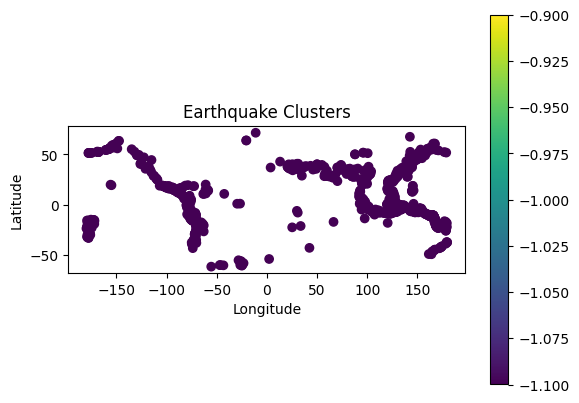

In [149]:
# Spatial Clustering with DBSCAN
coords = df[['latitude', 'longitude']]
db = DBSCAN(eps=0.3, min_samples=10).fit(coords)
df['cluster'] = db.labels_

# Plot clusters
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Earthquake Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [150]:
# Initialize the map with a lighter tile option
# Options include "Stamen Terrain", "OpenStreetMap", or "CartoDB positron" for light themes
world_map = folium.Map(location=[0, 0], zoom_start=1)
# Prepare heatmap data
heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]

# Add HeatMap layer
HeatMap(heat_data, radius=7, blur=10, max_zoom=1).add_to(world_map)

# Save the map to an HTML file and display it
world_map.save("earthquake_heatmap_light.html")
world_map

**Observations:**
- Indonesia suffered atleast 1 earthquake of magnitude 6.5 and above, every year between 1995-2023.
- A majority quakes are non-tsunami quakes, i.e., occuring on land, whereass tsunami quakaes accounted for just around 10% of total quakes in the country since 2001.
- The year 2007 was the year of earthquakes for Indonesia as around 13 quakes have occured during that year.
- Majority quakes in Indonesia are of magnitude 6.5 and 6.7.
- Japan had most number of quakes in 2011 (including the Fukushima quake).
- Tsunami quakes accounte for around 25% of total quakes in Japan.
- In Papua New Guinea, tsunami quakes are most common and represent over 50% share in total quakes.
- So far, Papua New Guinea has never experienced quakes above 8 magnitude.

# Temporal Analysis


In [151]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Encoding categorical variables
label_encoders = {}
for column in ['alert', 'net', 'magType']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Generate lagged features for magnitude (example with 1 and 2-day lags)
df['magnitude_lag1'] = df['magnitude'].rolling(window=2, min_periods=1).mean()
df['magnitude_lag2'] = df['magnitude'].rolling(window=3, min_periods=1).mean()

**Seasonal Decomposition**
* Purpose: Seasonal decomposition breaks down the earthquake occurrence frequency over time into its trend, seasonal, and residual components. This helps in understanding if there are consistent patterns.
* How: Using seasonal_decompose, we decompose monthly earthquake counts into their respective components, allowing us to observe long-term trends and periodic fluctuations

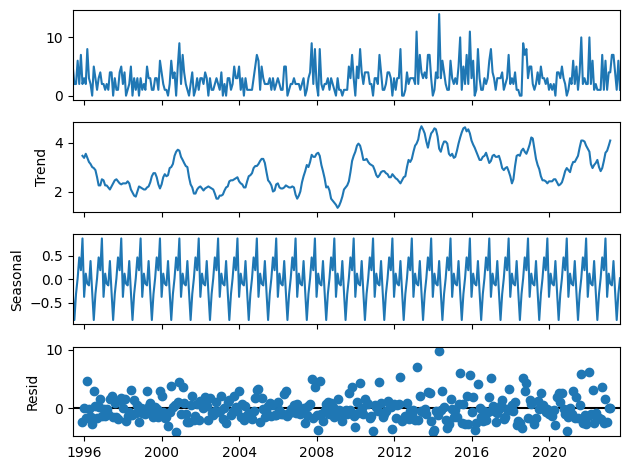

In [152]:
# Convert the date to datetime index
df.set_index('date', inplace=True)
frequency = df.resample('M').size()  # Monthly frequency of earthquakes

# Decompose time series
decomposition = seasonal_decompose(frequency, model='additive')
decomposition.plot()
plt.show()

Moving Average to Capture Trends
Purpose: A moving average smooths the data, helping reveal underlying trends without short-term fluctuations.
How: We calculate a 7-day moving average for magnitude, then plot it to show the general trend in earthquake magnitudes over time.

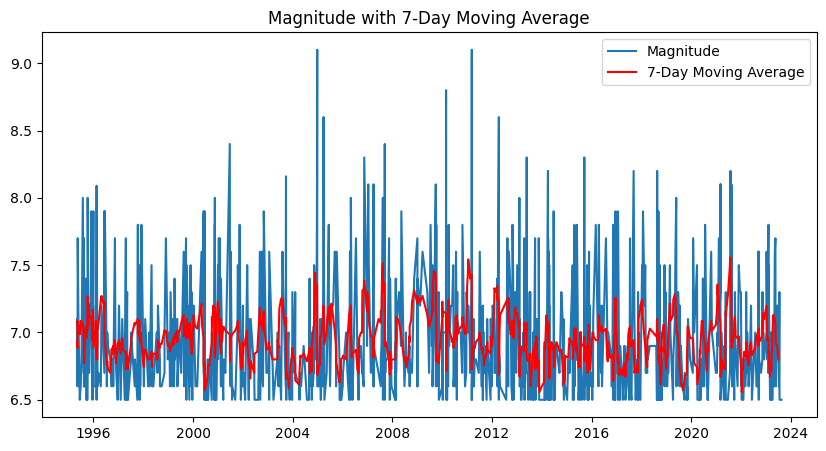

In [153]:
# Calculate moving averages
df['magnitude_MA7'] = df['magnitude'].rolling(window=7).mean()  # 7-day moving average

# Plot original and moving average
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['magnitude'], label='Magnitude')
plt.plot(df.index, df['magnitude_MA7'], label='7-Day Moving Average', color='red')
plt.legend()
plt.title("Magnitude with 7-Day Moving Average")
plt.show()

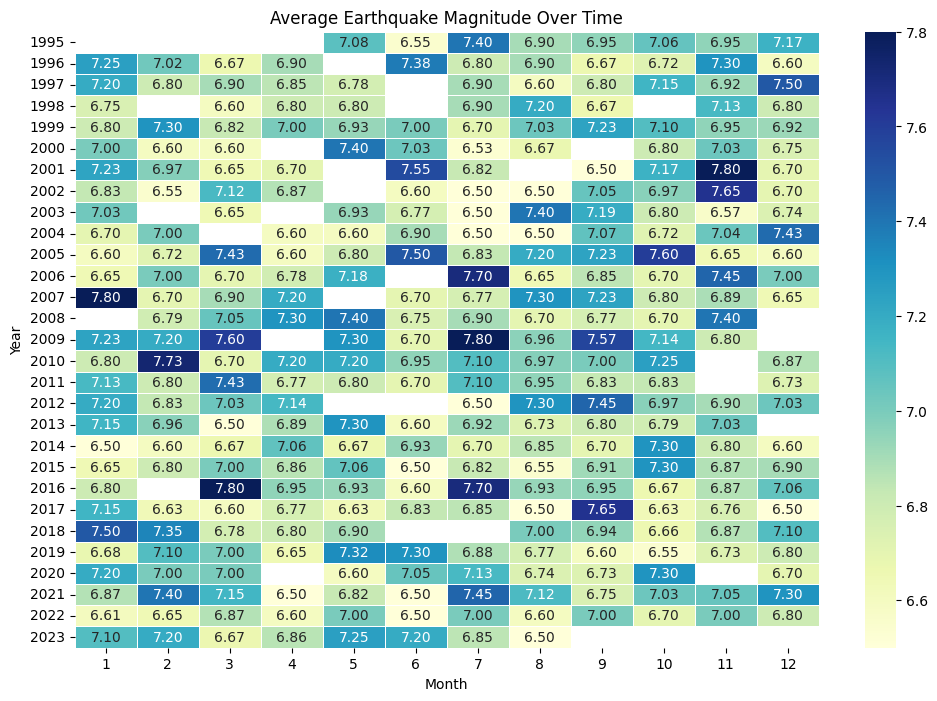

In [154]:
heatmap_data = df.groupby(['year', 'month'])['magnitude'].mean().unstack()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=.5)
plt.title('Average Earthquake Magnitude Over Time')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

Selecting the top 3 countries with most earthquakes for further temporal analysis

In [155]:
indo = df[df['country']=='Indonesia']['magnitude']
png = df[df['country']=='Papua New Guinea']['magnitude']
japan = df[df['country']=='Japan']['magnitude']
print(indo.shape)
print(png.shape)
print(japan.shape)

(150,)
(94,)
(75,)


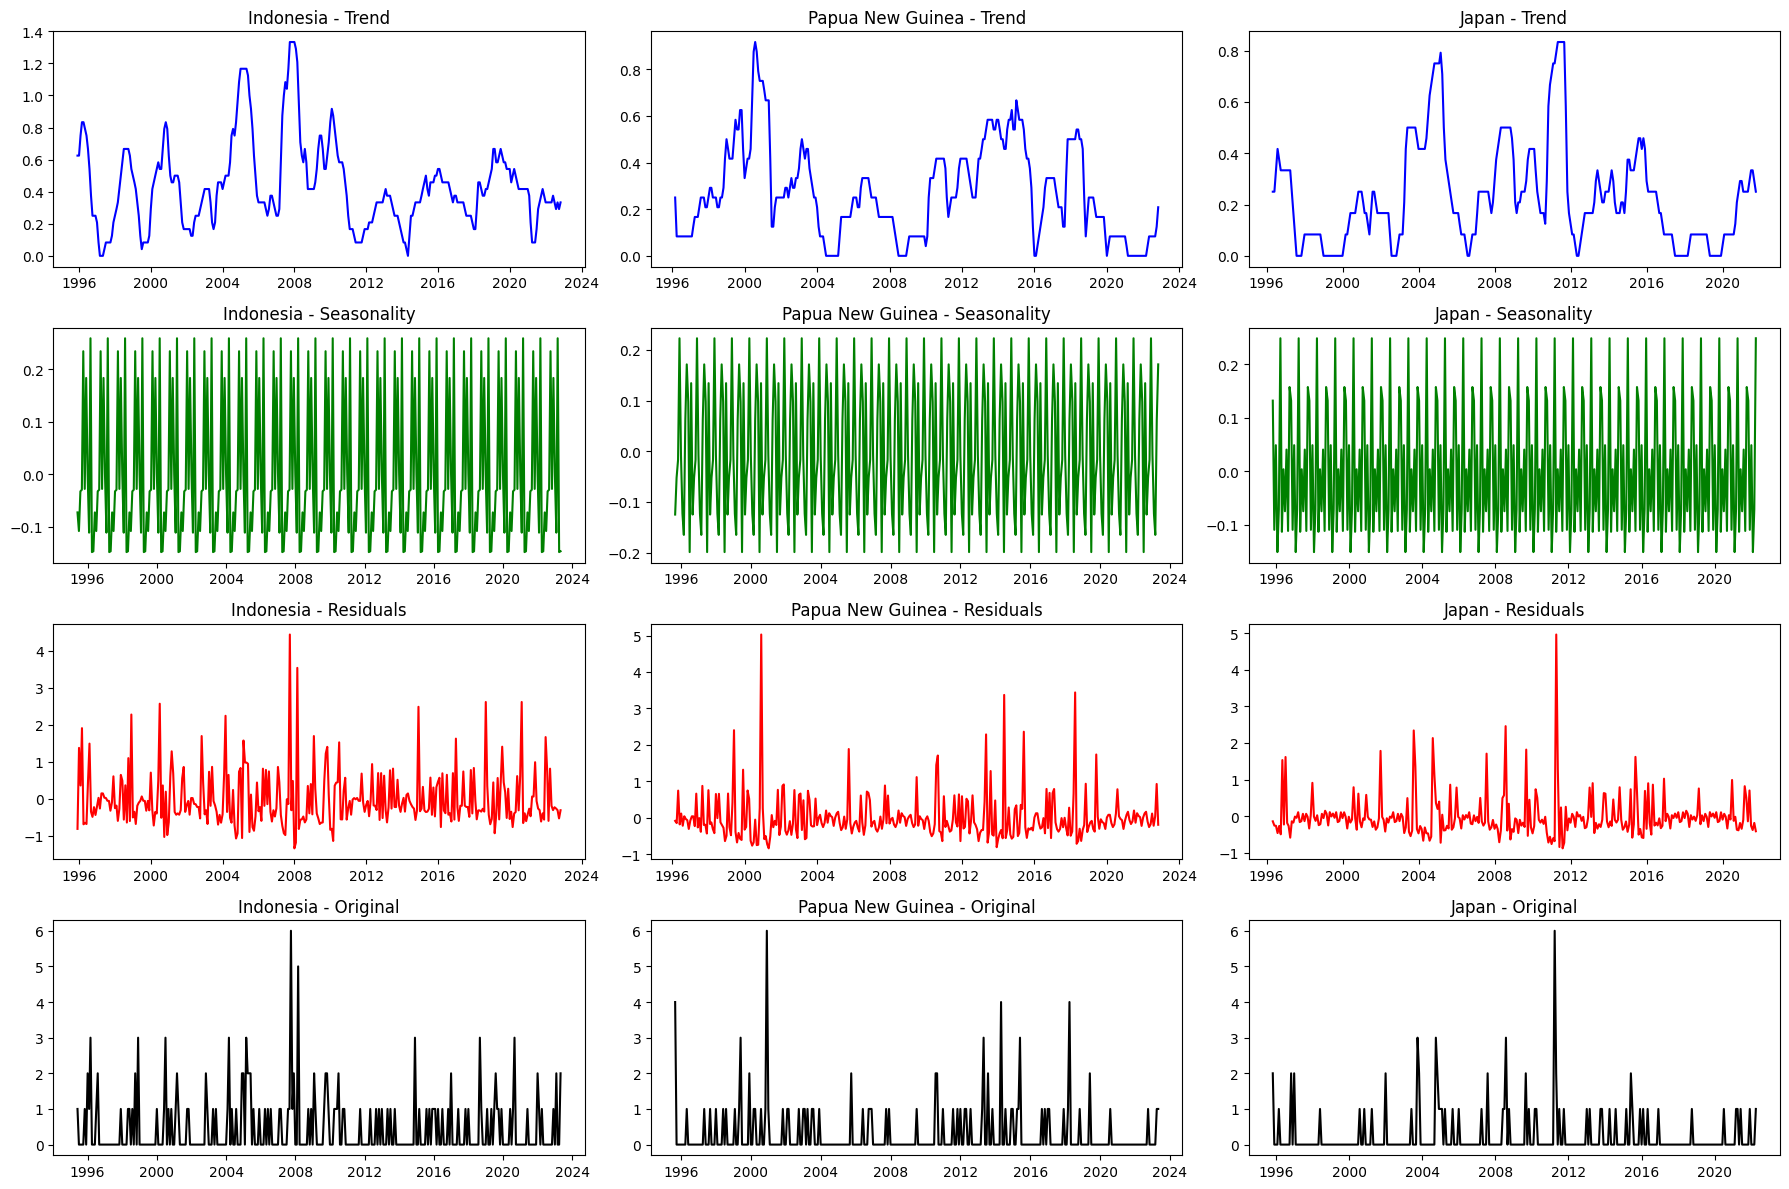

In [156]:
# Resample data to monthly frequency
indo_m = indo.resample('M').size()
png_m = png.resample('M').size()
japan_m = japan.resample('M').size()

# Create subplots for decomposition
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))

# Decompose Indonesia time series
decomposition_indo = seasonal_decompose(indo_m, model='additive', period=12)
axes[0, 0].plot(decomposition_indo.trend, color='blue')
axes[0, 0].set_title('Indonesia - Trend')
axes[1, 0].plot(decomposition_indo.seasonal, color='green')
axes[1, 0].set_title('Indonesia - Seasonality')
axes[2, 0].plot(decomposition_indo.resid, color='red')
axes[2, 0].set_title('Indonesia - Residuals')
axes[3, 0].plot(indo_m, color='black')
axes[3, 0].set_title('Indonesia - Original')

# Decompose Papua New Guinea time series
decomposition_png = seasonal_decompose(png_m, model='additive', period=12)
axes[0, 1].plot(decomposition_png.trend, color='blue')
axes[0, 1].set_title('Papua New Guinea - Trend')
axes[1, 1].plot(decomposition_png.seasonal, color='green')
axes[1, 1].set_title('Papua New Guinea - Seasonality')
axes[2, 1].plot(decomposition_png.resid, color='red')
axes[2, 1].set_title('Papua New Guinea - Residuals')
axes[3, 1].plot(png_m, color='black')
axes[3, 1].set_title('Papua New Guinea - Original')

# Decompose Japan time series
decomposition_japan = seasonal_decompose(japan_m, model='additive', period=12)
axes[0, 2].plot(decomposition_japan.trend, color='blue')
axes[0, 2].set_title('Japan - Trend')
axes[1, 2].plot(decomposition_japan.seasonal, color='green')
axes[1, 2].set_title('Japan - Seasonality')
axes[2, 2].plot(decomposition_japan.resid, color='red')
axes[2, 2].set_title('Japan - Residuals')
axes[3, 2].plot(japan_m, color='black')
axes[3, 2].set_title('Japan - Original')

# Adjust layout
fig.tight_layout()
plt.show()

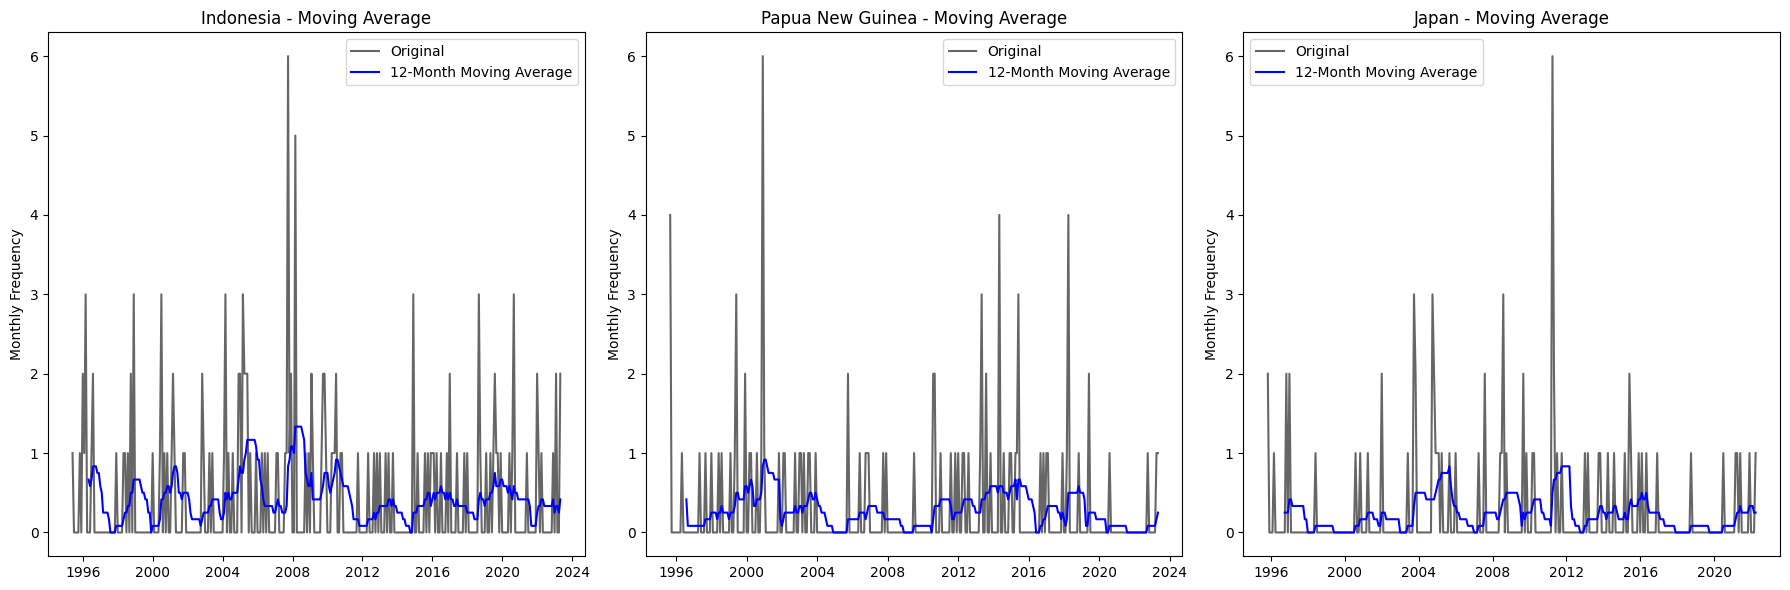

In [157]:
# Compute 12-month moving averages
indo_moving_avg = indo_m.rolling(window=12).mean()
png_moving_avg = png_m.rolling(window=12).mean()
japan_moving_avg = japan_m.rolling(window=12).mean()

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Indonesia Moving Average
axes[0].plot(indo_m, label='Original', color='black', alpha=0.6)
axes[0].plot(indo_moving_avg, label='12-Month Moving Average', color='blue')
axes[0].set_title('Indonesia - Moving Average')
axes[0].set_ylabel('Monthly Frequency')
axes[0].legend()

# Papua New Guinea Moving Average
axes[1].plot(png_m, label='Original', color='black', alpha=0.6)
axes[1].plot(png_moving_avg, label='12-Month Moving Average', color='blue')
axes[1].set_title('Papua New Guinea - Moving Average')
axes[1].set_ylabel('Monthly Frequency')
axes[1].legend()

# Japan Moving Average
axes[2].plot(japan_m, label='Original', color='black', alpha=0.6)
axes[2].plot(japan_moving_avg, label='12-Month Moving Average', color='blue')
axes[2].set_title('Japan - Moving Average')
axes[2].set_ylabel('Monthly Frequency')
axes[2].legend()

# Adjust layout
fig.tight_layout()
plt.show()

In [158]:
print("Indonesia:")
result = adfuller(indo_m.dropna())  # Drop NaN values
print('\tADF Statistic:', result[0])
print('\tp-value:', result[1])
if result[1] < 0.05:
    print("\tThe series is stationary.")
else:
    print("\tThe series is not stationary.")

print("Papua New Guinea:")
result = adfuller(png_m.dropna())  # Drop NaN values
print('\tADF Statistic:', result[0])
print('\tp-value:', result[1])
if result[1] < 0.05:
    print("\tThe series is stationary.")
else:
    print("\tThe series is not stationary.")

print("Japan:")
result = adfuller(japan_m.dropna())  # Drop NaN values
print('\tADF Statistic:', result[0])
print('\tp-value:', result[1])
if result[1] < 0.05:
    print("\tThe series is stationary.")
else:
    print("\tThe series is not stationary.")

Indonesia:
	ADF Statistic: -10.831592522894665
	p-value: 1.702653900832243e-19
	The series is stationary.
Papua New Guinea:
	ADF Statistic: -13.530127706326462
	p-value: 2.631511562027813e-25
	The series is stationary.
Japan:
	ADF Statistic: -15.262835208122723
	p-value: 4.834248859450722e-28
	The series is stationary.


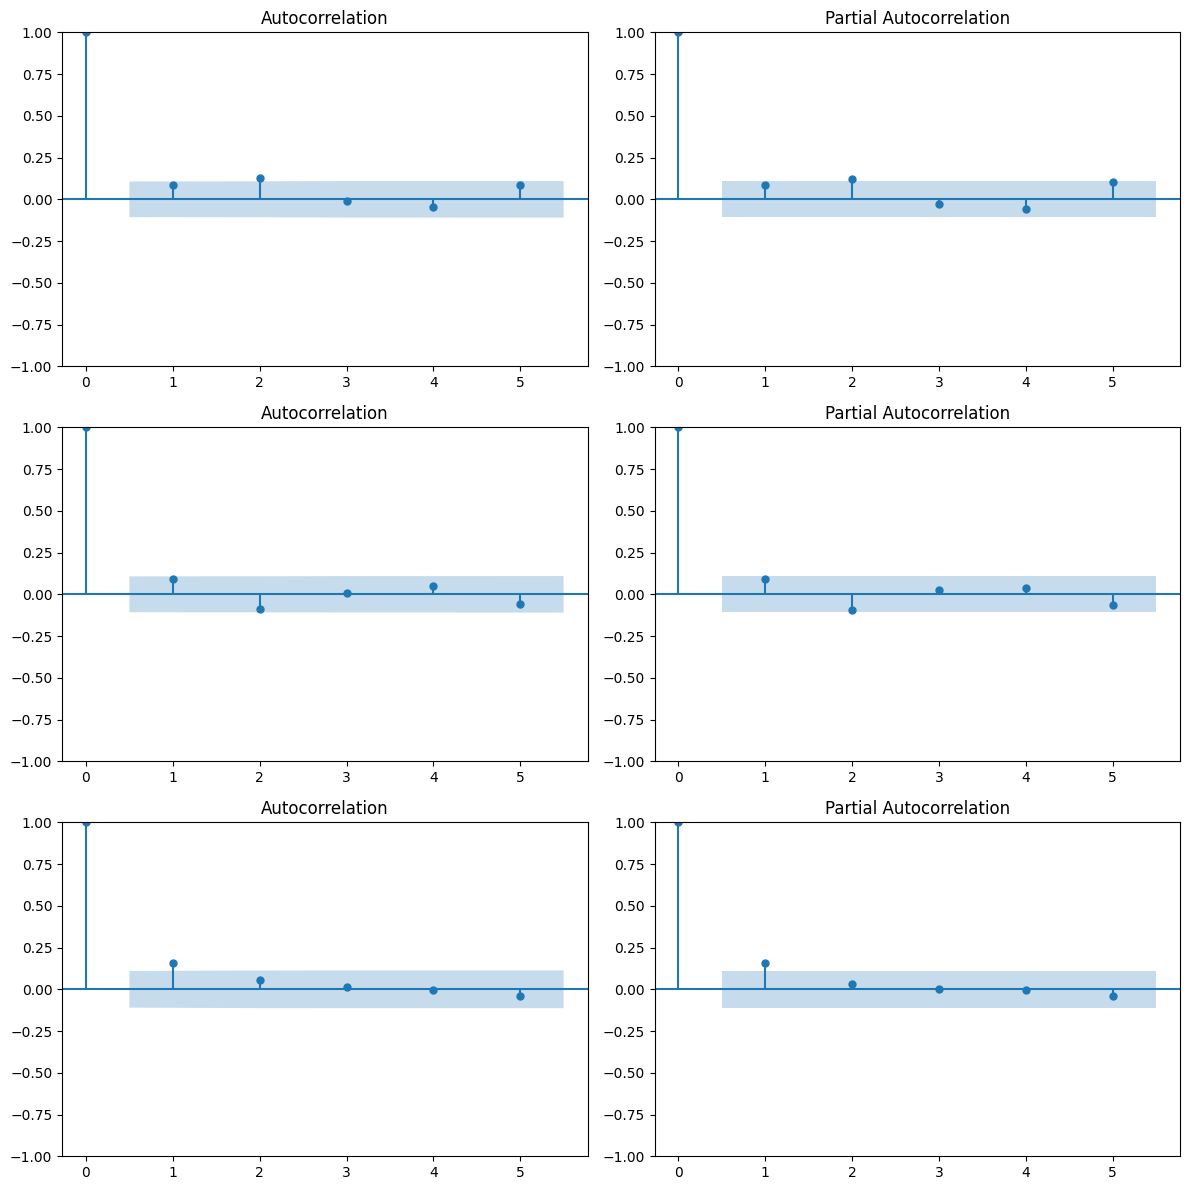

In [159]:
# Set up the subplots: 3 rows, 2 columns
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Indonesia
axs[0, 0].set_title("Indonesia: ACF")
plot_acf(indo_m.dropna(), lags=5, ax=axs[0, 0])
axs[0, 1].set_title("Indonesia: PACF")
plot_pacf(indo_m.dropna(), lags=5, ax=axs[0, 1])

# Papua New Guinea
axs[1, 0].set_title("Papua New Guinea: ACF")
plot_acf(png_m.dropna(), lags=5, ax=axs[1, 0])
axs[1, 1].set_title("Papua New Guinea: PACF")
plot_pacf(png_m.dropna(), lags=5, ax=axs[1, 1])

# Japan
axs[2, 0].set_title("Japan: ACF")
plot_acf(japan_m.dropna(), lags=5, ax=axs[2, 0])
axs[2, 1].set_title("Japan: PACF")
plot_pacf(japan_m.dropna(), lags=5, ax=axs[2, 1])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Causal Analysis
## Using Granger Causality to analyze if past magnitudes predict future magnitudes.

**Granger Causality Test:**
The grangercausalitytests function performs the Granger causality test for specified lags (1 and 2 in this case).
It outputs various statistics, including p-values, which you can interpret to see if one variable Granger-causes the other.

**Visualizing Time Series Data:**
Two subplots show the time series data for Magnitude and Depth. This helps in visually assessing their trends and patterns.

**Correlation Analysis:**
The Pearson correlation coefficient is calculated to determine the strength of the linear relationship between Magnitude and Depth. A correlation value closer to 1 or -1 indicates a strong relationship, while a value around 0 suggests a weak relationship.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6021  , p=0.4380  , df_denom=993, df_num=1
ssr based chi2 test:   chi2=0.6039  , p=0.4371  , df=1
likelihood ratio test: chi2=0.6038  , p=0.4371  , df=1
parameter F test:         F=0.6021  , p=0.4380  , df_denom=993, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4044  , p=0.6675  , df_denom=990, df_num=2
ssr based chi2 test:   chi2=0.8129  , p=0.6660  , df=2
likelihood ratio test: chi2=0.8125  , p=0.6661  , df=2
parameter F test:         F=0.4044  , p=0.6675  , df_denom=990, df_num=2
P-values for Granger causality test:
{1: 0.438, 2: 0.6675}


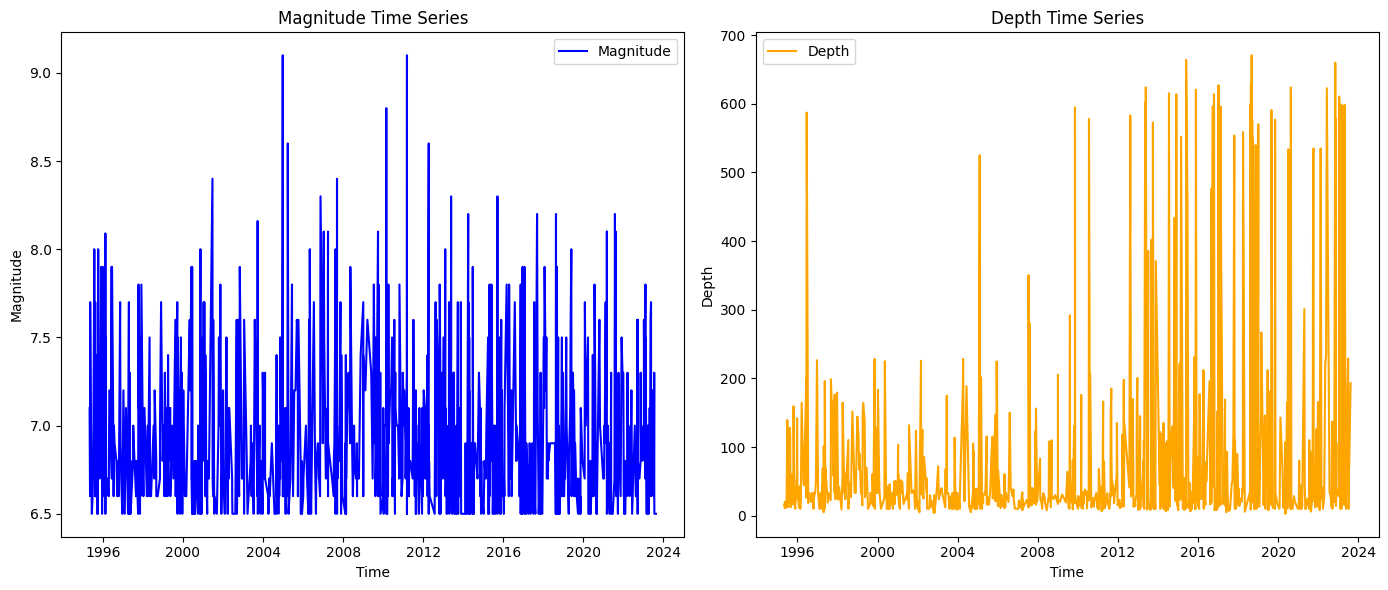

Correlation between magnitude and depth: 0.0208


In [160]:
# Granger causality test with magnitude and depth
results = grangercausalitytests(df[['magnitude', 'depth']].dropna(), maxlag=2)

# Extracting and printing p-values
p_values = {lag: round(results[lag][0]['ssr_ftest'][1], 4) for lag in results}
print("P-values for Granger causality test:")
print(p_values)

# Plotting the time series data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df['magnitude'], label='Magnitude', color='blue')
plt.title('Magnitude Time Series')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df['depth'], label='Depth', color='orange')
plt.title('Depth Time Series')
plt.xlabel('Time')
plt.ylabel('Depth')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation analysis
correlation = df[['magnitude', 'depth']].corr().iloc[0, 1]
print(f"Correlation between magnitude and depth: {correlation:.4f}")

- There is no correlation between Magnitude and Depth of Earthquakes.

# Predictive Modeling

### 1. Predicting Magnitude of Earthquake

In [161]:
# Splitting the data
X = df[['depth', 'latitude', 'longitude', 'magnitude_lag1', 'magnitude_lag2', 'cluster']]
y = df['magnitude']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Regression
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 100 * (1 - mape)  # pseudo accuracy as percentage

print("RMSE:", rmse)
print("R^2:", r2)
print("Accuracy:", accuracy, "%")

RMSE: 0.3224145483814074
R^2: 0.41007575572474575
Accuracy: 96.5589963790716 %


### 2. Predicting Risk Level of Earthquakes

In [162]:
# Creating more granular risk levels based on magnitude ranges
df['risk_level'] = pd.cut(
    df['magnitude'], 
    bins=[6.5, 6.7, 7.1, 9.1], 
    labels=[0, 1, 2], 
    include_lowest=True
)

# Defining features and target
features = df[['latitude', 'longitude', 'depth', 'magnitude', 'tsunami']]
target = df['risk_level']

# Stratified Train-Test Split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3
)

# Initialize and train the Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(clf, features, target, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Accuracy: 0.93
F1 Score: 0.9293436936615348
Confusion Matrix:
 [[120   0   0]
 [ 19  91   0]
 [  0   2  68]]
Cross-Validation Scores: [0.955      0.98       0.96482412 0.9798995  1.        ]
Mean CV Score: 0.9759447236180904


### 3. Spatial Graph model with respect to Magnitude

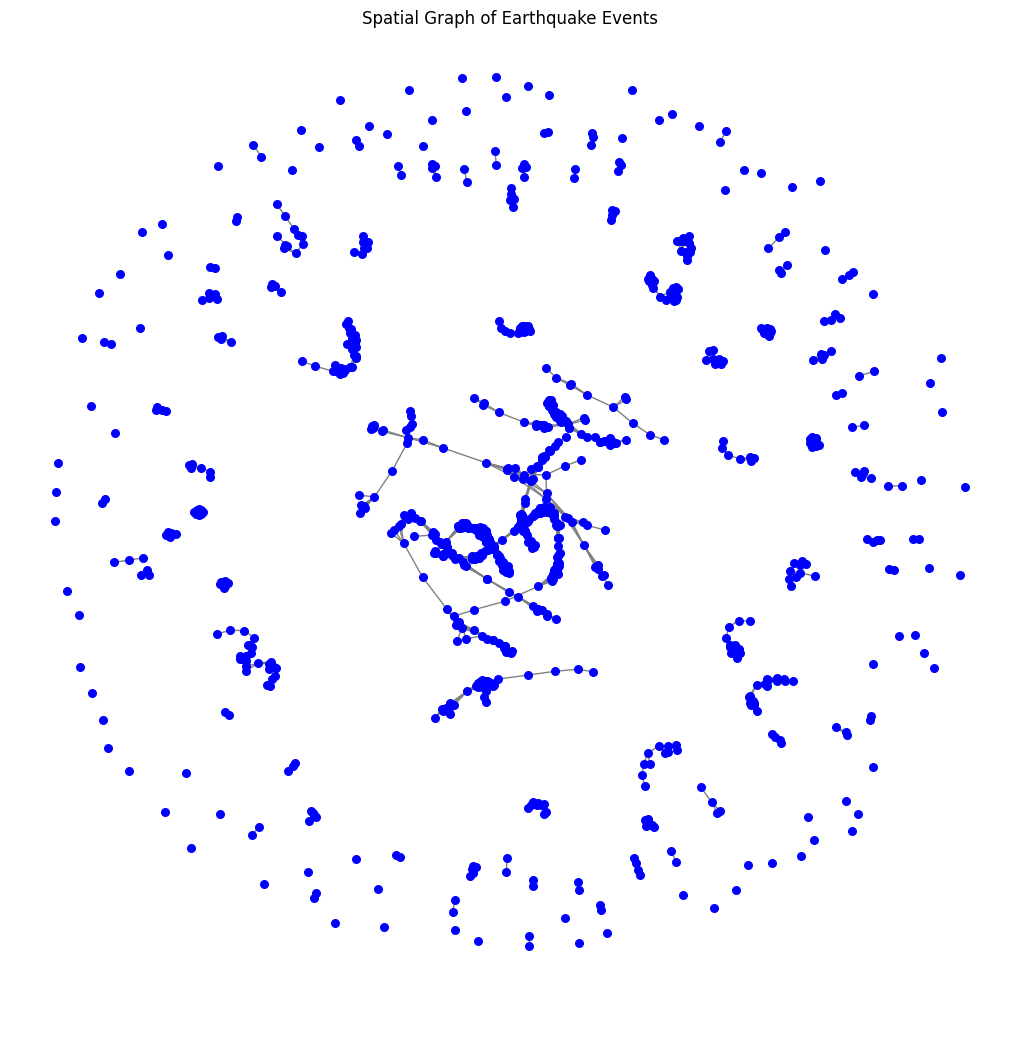

In [163]:
# Assuming 'alert', 'net', 'magType', 'country' are already encoded
# Selecting relevant features for the nodes
features = df[['latitude', 'longitude', 'depth', 'cdi', 'mmi', 'alert', 'tsunami', 'sig']].values
target = df['magnitude'].values

# Calculate spatial proximity (e.g., within 2 degrees of lat/lon for edges)
distance_thresh = 2  # degrees
coords = df[['latitude', 'longitude']].values
distances = distance_matrix(coords, coords)
adjacency_matrix = (distances < distance_thresh) & (distances > 0)

# Convert adjacency matrix and features to Graph format
edge_index = np.array(np.where(adjacency_matrix)).T
x = features.astype(np.float32)
y = target.astype(np.float32)

# Plot the graph (optional, smaller sample for clarity)
G = nx.Graph()
G.add_nodes_from(range(len(df)))
G.add_edges_from(edge_index)

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=30, node_color="blue", edge_color="gray")
plt.title("Spatial Graph of Earthquake Events")
plt.show()

# Ensure the adjacency matrix is float and in sparse format
adjacency_matrix = adjacency_matrix.astype(float)
adjacency_matrix_sparse = sp.coo_matrix(adjacency_matrix)

# Create the Spektral Graph object with the sparse adjacency matrix
graph = Graph(x=features, a=adjacency_matrix_sparse, y=target)